# Testing Modern RL Algorithms on Financial Timeseries

While the classic Deep Q-Network (DQN) has been an effective algorithm in RL, advancements since the famous Atari 2600 paper (), have given rise to a several  alternatives which are often considered to be better. In this notebook, we’ll consider options for RL algorithm beyond DQN and compare these modern algorithms across gaming and financial environments.

## The Limitations of DQN

DQN, based on Q-learning and neural networks, revolutionized RL by achieving impressive results in video games. It is simple and effective for environments with discrete actions. However, DQN also has its limitations. For instance, it struggles in dynamic or continuous-action environments. DQN also has a tendency to overestimate action values, since it uses the same network to select actions (action selection) and evaluate their values (action evaluation).

## Modern RL Agorithms

Let’s explore some of the noteworthy modern RL algorithms:

1. **Double Deep Q-Network (DDQN)**: DDQN improves on DQN's tendency to overestimate action values. In Double DQN, overestimation is mitigated by decoupling action selection and evaluation. This is achieved by maintaining two neural networks, an Online Network and a Target Network.

1. **Proximal Policy Optimization (PPO)**: PPO strikes a balance between stability and sample efficiency. It iteratively updates policies while constraining significant changes, making it suitable for both discrete and continuous action spaces.
    
2. **Advantage Actor-Critic (A2C)**: A2C combines actor-critic methods with advantage estimation, leading to more efficient gradient updates. It excels in high-dimensional action spaces.
    
3. **Soft Actor-Critic (SAC)**: SAC optimizes stochastic policies, gracefully handling continuous actions. Its exploration-friendly design encourages robust learning.
    
4. **Twin Delayed Deep Deterministic Policy Gradient (TD3)**: TD3 enhances DDPG by incorporating twin critics and target policy smoothing. It shines in continuous control tasks.
    
5. **Rainbow**: An ensemble of DQN variants, Rainbow integrates improvements like prioritized experience replay, dueling networks, and distributional value estimation.
    
6. **Multi-Agent Reinforcement Learning (MARL)**: MARL algorithms, including independent learners and value decomposition, tackle multi-agent scenarios [[1](https://arxiv.org/pdf/2006.07869v1)].


In [13]:
import os
import gymnasium as gym
import gym_anytrading
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3 import A2C, PPO, DQN # select model
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import quantstats as qs

# Retrieve Data

In [6]:
import tpqoa
api = tpqoa.tpqoa('../oanda.cfg')
df = api.get_history(instrument='EUR_USD', start='2020-01-01', end='2021-04-01', granularity='M5', price='M')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92706 entries, 2020-01-01 22:00:00 to 2021-03-31 23:55:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         92706 non-null  float64
 1   h         92706 non-null  float64
 2   l         92706 non-null  float64
 3   c         92706 non-null  float64
 4   volume    92706 non-null  int64  
 5   complete  92706 non-null  bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 4.3 MB


In [16]:
df = df.rename_axis('Date')
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Complete']
df.head()

,Open,High,Low,Close,Volume,Complete
Date,,,,,,
2020-01-01 22:00:00,1.12124,1.12146,1.12124,1.12132,9,True
2020-01-01 22:05:00,1.12137,1.12137,1.12125,1.12125,5,True
2020-01-01 22:10:00,1.12129,1.12129,1.12125,1.12125,2,True
2020-01-01 22:15:00,1.12135,1.12155,1.12134,1.12146,12,True
2020-01-01 22:20:00,1.12143,1.12154,1.12143,1.12154,4,True


# Create the Agent

In this instance we will use stable-baselines3's `make_vec_env`, which serves the purpose of creating a [vectorized environment](https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/multiprocessing_rl.ipynb). This method stacks multiple independent environments into a single environment, allowing an RL agent to train on n environments per step instead of just one.

In [32]:
window_size = 50
start_index = window_size
end_index = len(df)


def create_env(df, start_index, end_index, window_size):
    env = gym.make('forex-v0', df=df,  frame_bound=(start_index, end_index), window_size=window_size)
    env.trade_fee = 0
    return env


def env_maker():
    return create_env(df, start_index, end_index, window_size)

# Create 100 parallel environments
env = make_vec_env(lambda: env_maker(), n_envs=100) 
model = A2C(MlpPolicy, env, verbose=1) # PPO(MlpPolicy, env, verbose=1)


Using cpu device


# Training

In [18]:
model.learn(total_timesteps=10_000_000)

-------------------------------------
| time/                 |           |
|    fps                | 7189      |
|    iterations         | 100       |
|    time_elapsed       | 6         |
|    total_timesteps    | 50000     |
| train/                |           |
|    entropy_loss       | -0.000751 |
|    explained_variance | 0.276     |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 2.73e-08  |
|    value_loss         | 1.73e-07  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 7402      |
|    iterations         | 200       |
|    time_elapsed       | 13        |
|    total_timesteps    | 100000    |
| train/                |           |
|    entropy_loss       | -0.000516 |
|    explained_variance | -15.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | 6.69e-09  |
|    value_l

In [21]:
import os

# Create save dir
# save_dir = "./"
# os.makedirs(save_dir, exist_ok=True)

model.save(f"../models/7 April 2021 A2C EURUSD")

In [33]:
model.load(f"../models/7 April 2021 A2C EURUSD")

# Using Quantstats to generate a Report on The Model

/usr/local/Caskroom/mambaforge/base/envs/qfc/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.history to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.history` for environment variables or `env.get_wrapper_attr('history')` that will search the reminding wrappers.
  logger.warn(


/usr/local/Caskroom/mambaforge/base/envs/qfc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/Caskroom/mambaforge/base/envs/qfc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/Caskroom/mambaforge/base/envs/qfc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain t

                           Strategy
-------------------------  ----------
Start Period               2020-01-02
End Period                 2021-03-31
Risk-Free Rate             0.0%
Time in Market             26.0%

Cumulative Return          -99.77%
CAGR﹪                     -96.57%

Sharpe                     -4.29
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -3.99
Sortino                    -4.6
Smart Sortino              -4.27
Sortino/√2                 -3.25
Smart Sortino/√2           -3.02
Omega                      0.17

Max Drawdown               -99.77%
Longest DD Days            455
Volatility (ann.)          0.38%
Calmar                     -0.97
Skew                       -2.22
Kurtosis                   48.77

Expected Daily %           -0.01%
Expected Monthly %         -33.31%
Expected Yearly %          -95.21%
Kelly Criterion            -80.08%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.05%
Expected Shortfall (cVaR)  -0.05%

Max Consecuti

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-02,2021-03-31,2021-03-31,455,-99.77036,-99.756982


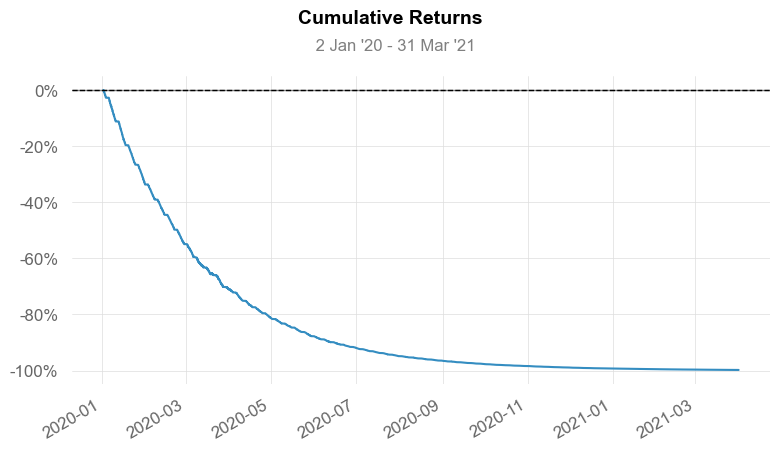

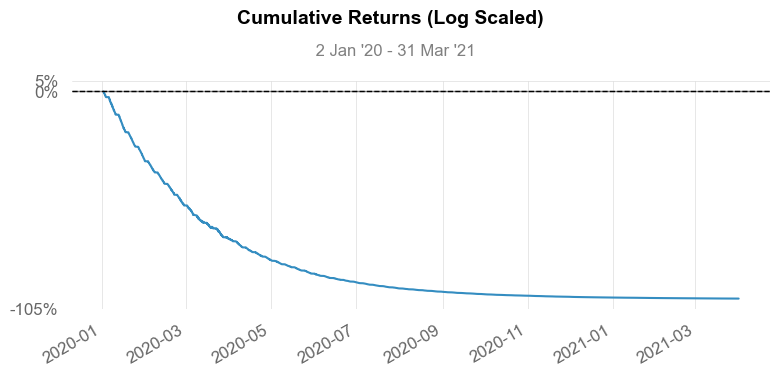

/usr/local/Caskroom/mambaforge/base/envs/qfc/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
/usr/local/Caskroom/mambaforge/base/envs/qfc/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


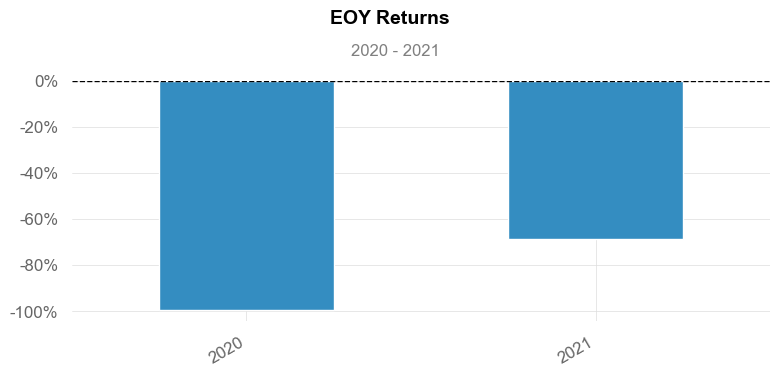

/usr/local/Caskroom/mambaforge/base/envs/qfc/lib/python3.10/site-packages/quantstats/_plotting/core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


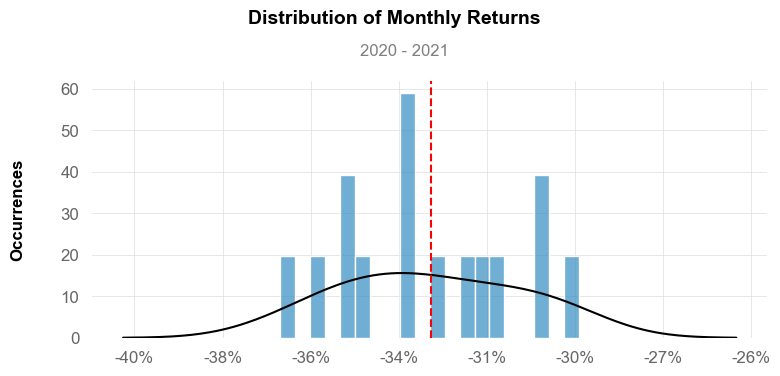

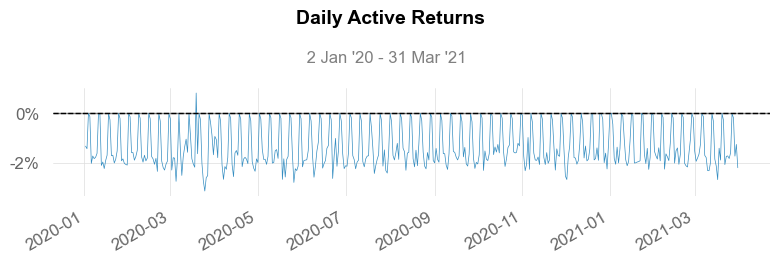

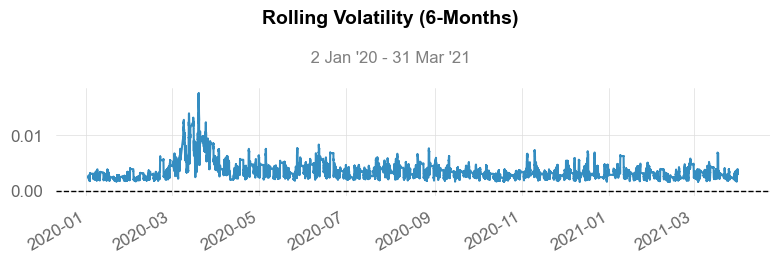

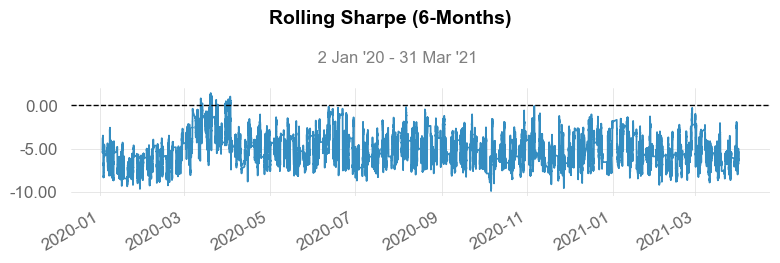

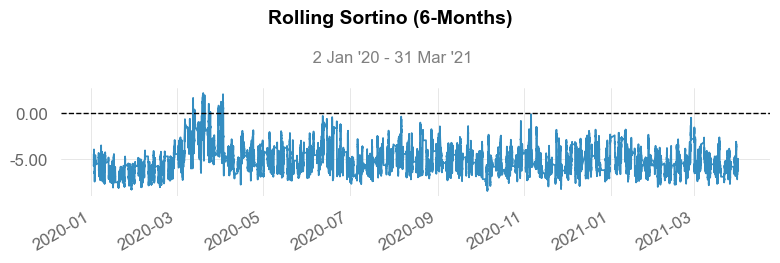

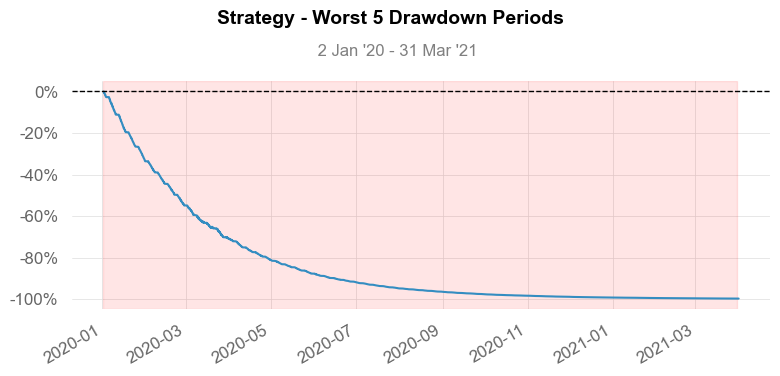

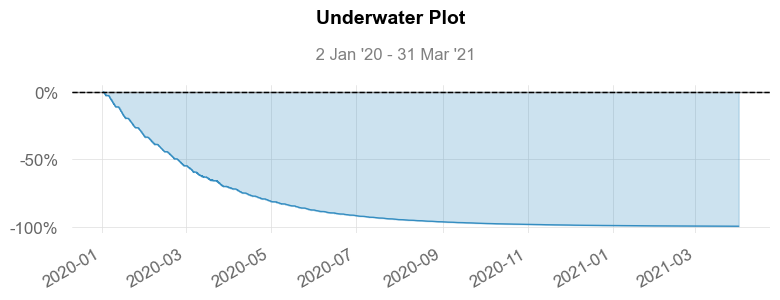

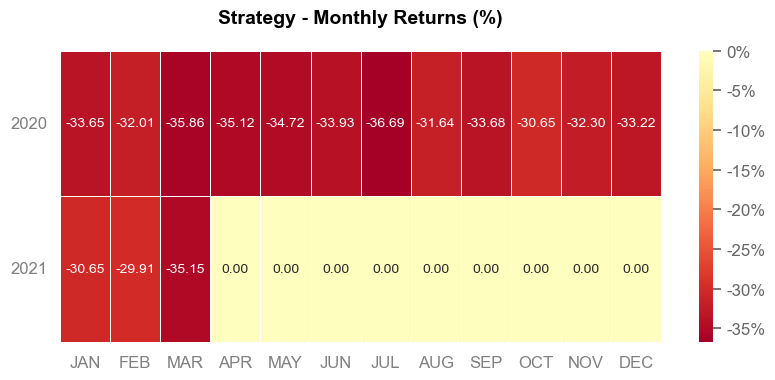

/usr/local/Caskroom/mambaforge/base/envs/qfc/lib/python3.10/site-packages/quantstats/_plotting/core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
/usr/local/Caskroom/mambaforge/base/envs/qfc/lib/python3.10/site-packages/quantstats/_plotting/core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
/usr/local/Caskroom/mambaforge/base/envs/qfc/lib/python3.10/site-pack

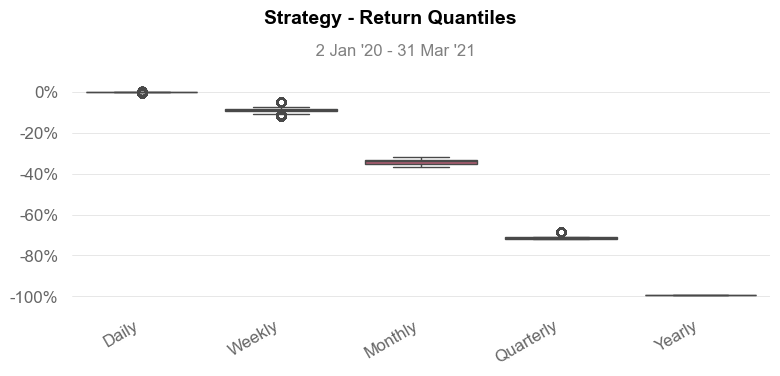

In [48]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
